# **Comparative Analysis of CNNs and ViTs for Parkinson's Disease Classification from Audio Signals**

#**Using ViT**

**Importing the required libraries**

In [ ]:
!pip install timm
import numpy as np
import pandas as pd
import tqdm as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import glob
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
from  torchvision import transforms 
from timm.models.vision_transformer import VisionTransformer 
import timm
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.8 MB/s eta 0:00:00


In [ ]:
#mount gdrive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#**Part 1 - Using Wavelet Transform**

**Load the train and test data (wavelet scalograms)**

In [ ]:
train_path = '/content/drive/MyDrive/EE769Project/Data/wavelet_scalograms/train'
test_path = '/content/drive/MyDrive/EE769Project/Data/wavelet_scalograms/val'

**Prepare train and test data**

**Feature extraction using ViT architecture**

In [ ]:
from tqdm import tqdm
def extract_vit_features(image_folder_path,model_name):
    # Load the pre-trained ViT model   
    model = timm.create_model(model_name, pretrained=True)

    # Set the model to evaluation mode
    model.eval()

    # Set up the preprocessing transform
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load image dataset
    image_dataset = ImageFolder(image_folder_path, transform=transform)

    # Initialize lists to store features and labels
    vit_features = []
    labels = []

    # Loop through each image in the dataset and extract ViT features
    for image, label in tqdm(image_dataset):
        # Preprocess the image
        image = image.unsqueeze(0)  # add batch dimension
        image = image.cpu() 
        with torch.no_grad():
            # Pass the image through the ViT model
            features = model.forward_features(image)
            # Extract features from the last transformer encoder layer
            last_layer_features = features[:, -1, :]
            # Append the features and label to the corresponding lists
            vit_features.append(last_layer_features.detach().cpu().numpy().squeeze())
            labels.append(label)

    # Convert the lists to numpy arrays and return
    return (np.array(vit_features), np.array(labels))




We will compare the performance of 4 ViT models used for feature extraction -
1. Base model, patch size = 16
2. Base model, patch size = 32
3. Large model, patch size = 16
4. Large model, patch size = 32 

Then, 4 different models will be used for the binary classification task, and their performance will be compared. 

#**ViT Model-1: Base, patch size = 16**

In [ ]:
model_name = 'vit_base_patch16_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [30:21<00:00,  1.07it/s]


In [ ]:
print("Number of features obtained:", len(train_features[0]))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)

Number of features obtained: 768
Shape of train data: (1952, 768)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_base_patch16_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features[0]))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


100%|██████████| 46/46 [01:02<00:00,  1.35s/it]

Number of features obtained: 768
Shape of test data: (46, 768)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
#Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50], 'gamma': [0.01, 0.1, 1,10]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500], 'max_depth': [0.5,1,2,5, 10]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------

print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback

Logistic regression:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.90      1.00      0.95        26

    accuracy                           0.93        46
   macro avg       0.95      0.93      0.93        46
weighted avg       0.94      0.93      0.93        46

[[17  3]
 [ 0 26]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 10, 'gamma': 0.01}
Best score  for SVM with Kernel RBF Classification:  0.5763459899009772
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        20
           1       0.91      0.77      0.83        26

    accuracy                           0.83        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.84      0.83      0.83        46

[[18  2]
 [ 6 20]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 10, 'n_estimators': 200}
Best score 

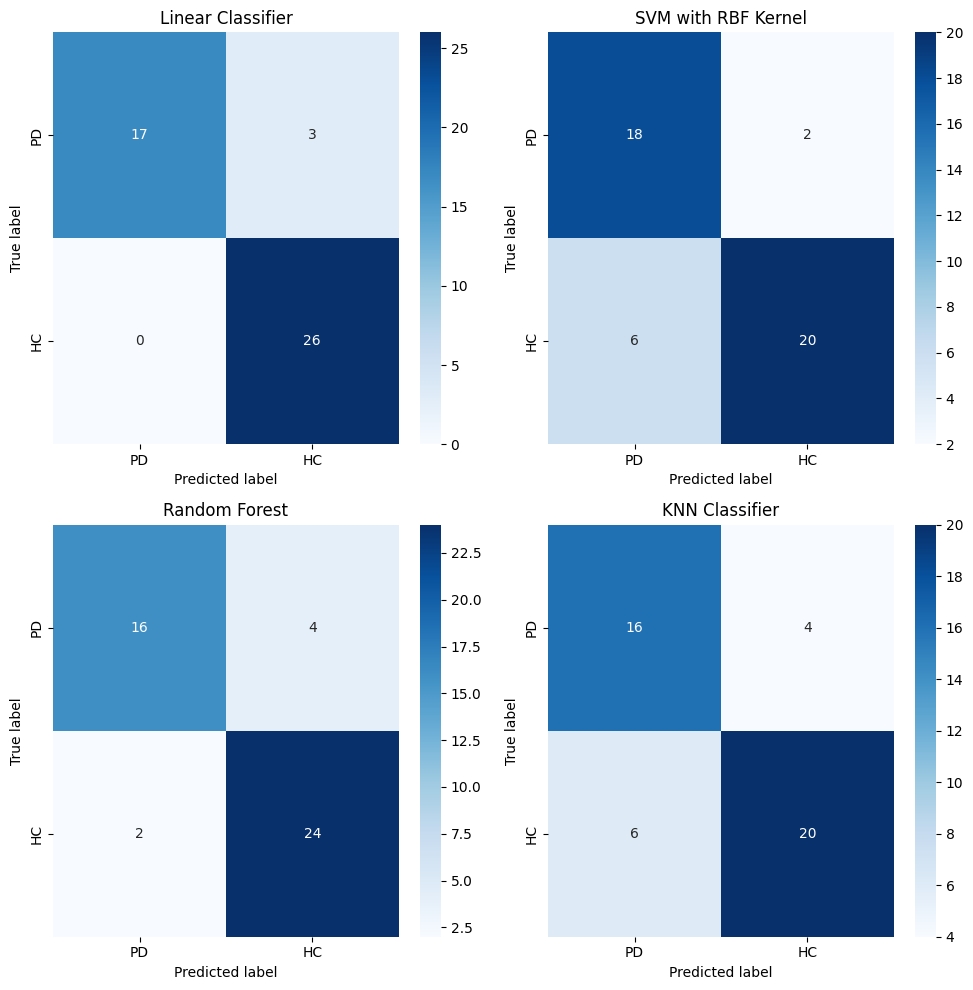

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


In [ ]:
#Maximum Voting Classifier

# **ViT Model-2 base path size =32**

In [ ]:
model_name = 'vit_base_patch32_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [06:46<00:00,  4.81it/s]


In [ ]:
print("Number of features obtained:", len(train_features[0]))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)



Number of features obtained: 768
Shape of train data: (1952, 768)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_base_patch32_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features[0]))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


100%|██████████| 46/46 [00:10<00:00,  4.56it/s]

Number of features obtained: 768
Shape of test data: (46, 768)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
# Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50,100], 'gamma': [0.01, 0.1, 1,10]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500,1000], 'max_depth': [0.5,1,2,5, 10, 20]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------

print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Tracebac

Logistic regression:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.93      0.96      0.94        26

    accuracy                           0.93        46
   macro avg       0.94      0.93      0.93        46
weighted avg       0.94      0.93      0.93        46

[[18  2]
 [ 1 25]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 1, 'gamma': 0.01}
Best score  for SVM with Kernel RBF Classification:  0.6552980523313003
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.92      0.88      0.90        26

    accuracy                           0.89        46
   macro avg       0.89      0.89      0.89        46
weighted avg       0.89      0.89      0.89        46

[[18  2]
 [ 3 23]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 20, 'n_estimators': 200}
Best score  

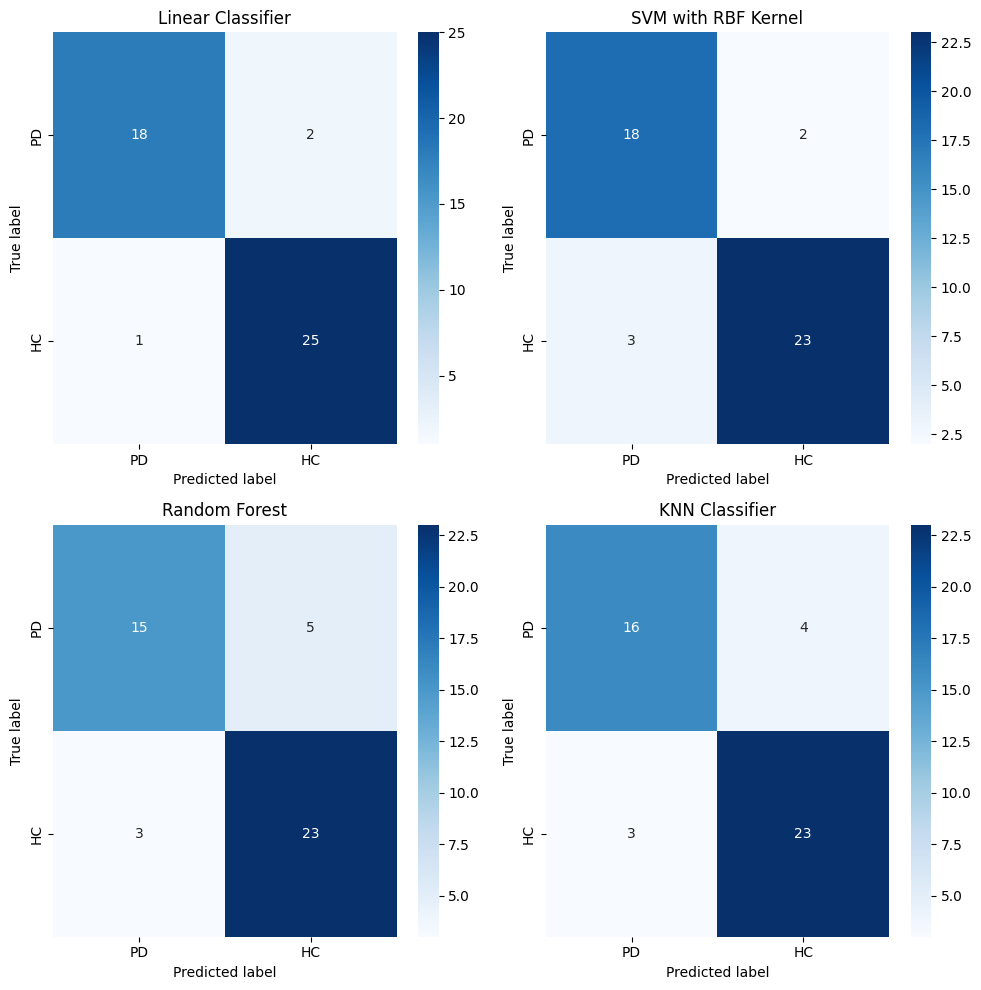

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


#**ViT Model 3: large, patch size=16**

In [ ]:
model_name = 'vit_large_patch16_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [1:12:47<00:00,  2.24s/it]


In [ ]:
print("Number of features obtained:", len(train_features[0]))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)



Number of features obtained: 1024
Shape of train data: (1952, 1024)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_large_patch16_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features[0]))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


100%|██████████| 46/46 [01:45<00:00,  2.30s/it]

Number of features obtained: 1024
Shape of test data: (46, 1024)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
# Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50], 'gamma': [1e-5,1e-4, 0.01, 0.1]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500], 'max_depth': [0.5,1,2,5]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------

print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback

Logistic regression:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.96      0.88      0.92        26

    accuracy                           0.91        46
   macro avg       0.91      0.92      0.91        46
weighted avg       0.92      0.91      0.91        46

[[19  1]
 [ 3 23]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 50, 'gamma': 0.0001}
Best score  for SVM with Kernel RBF Classification:  0.7341346973572037
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.92      0.92      0.92        26

    accuracy                           0.91        46
   macro avg       0.91      0.91      0.91        46
weighted avg       0.91      0.91      0.91        46

[[18  2]
 [ 2 24]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 5, 'n_estimators': 500}
Best score

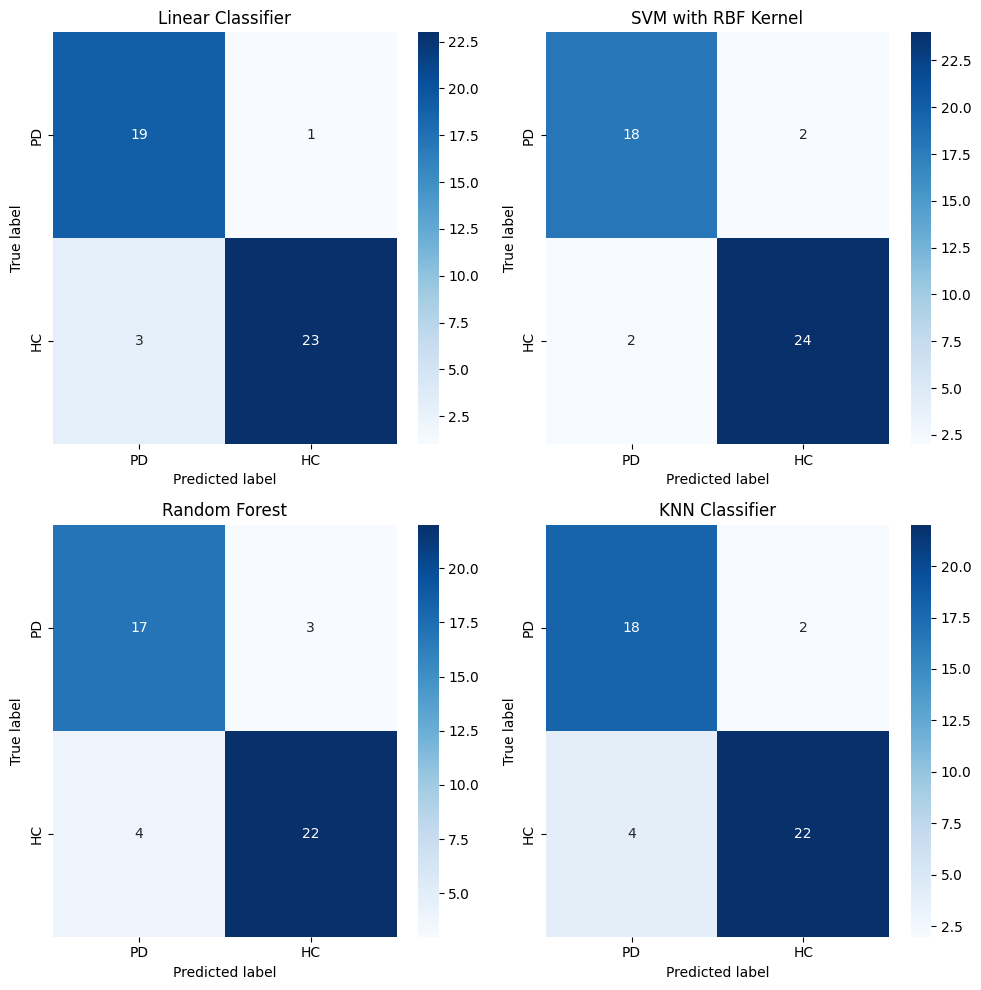

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


#**ViT Model-4: large, patch size=32**

In [ ]:
model_name = 'vit_large_patch32_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [22:24<00:00,  1.45it/s]


In [ ]:
print("Number of features obtained:", len(train_features[0]))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)



Number of features obtained: 1024
Shape of train data: (1952, 1024)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_large_patch32_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features[0]))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
# Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1500, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50], 'gamma': [1e-5,1e-4,0.01, 0.1, 1]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500], 'max_depth': [1,2,5,10]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------
print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


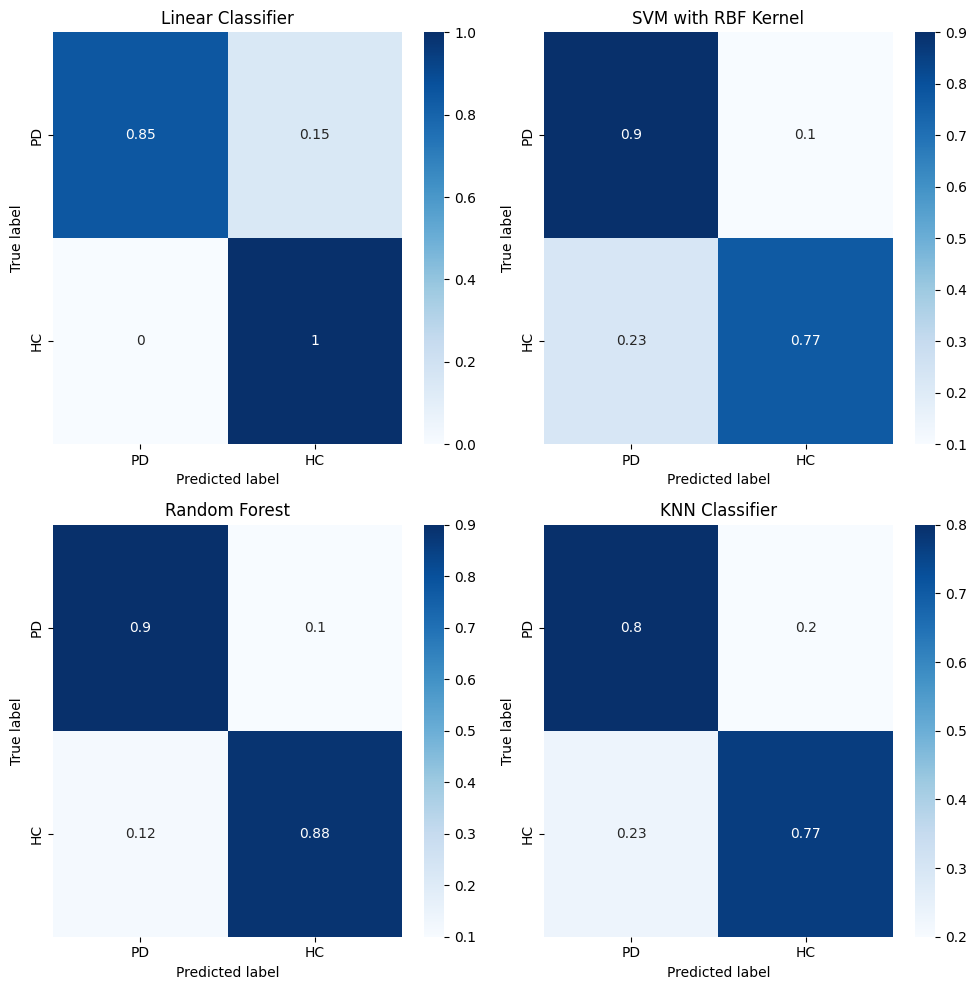

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


# **Cross Wavelet**

In [ ]:
train_path = '/content/drive/MyDrive/augmented_main_images_cross_wavelet_binary'
test_path = '/content/drive/MyDrive/val1'

#**ViT Model-1: Base, patch size = 16**

In [ ]:
model_name = 'vit_base_patch16_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [21:55<00:00,  1.48it/s]


In [ ]:
print("Number of features obtained:", len(train_features))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)



Number of features obtained: 1952
Shape of train data: (1952, 768)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_base_patch32_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]

Number of features obtained: 46
Shape of test data: (46, 768)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
# Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50,100], 'gamma': [0.01, 0.1, 1,10]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500,1000], 'max_depth': [1,2,5, 10, 20]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------
from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(labels_test,prediction_knn))

# Print results
print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceb

Accuracy=  0.391304347826087
Logistic regression:
              precision    recall  f1-score   support

           0       0.44      1.00      0.62        20
           1       1.00      0.04      0.07        26

    accuracy                           0.46        46
   macro avg       0.72      0.52      0.34        46
weighted avg       0.76      0.46      0.31        46

[[20  0]
 [25  1]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 10, 'gamma': 0.01}
Best score  for SVM with Kernel RBF Classification:  0.5814676372221129
              precision    recall  f1-score   support

           0       0.43      1.00      0.61        20
           1       0.00      0.00      0.00        26

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46

[[20  0]
 [26  0]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 10, 'n_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.42      0.95      0.58        20
           1       0.00      0.00      0.00        26

    accuracy                           0.41        46
   macro avg       0.21      0.47      0.29        46
weighted avg       0.18      0.41      0.25        46

[[19  1]
 [26  0]]
KNN:
              precision    recall  f1-score   support

           0       0.40      0.85      0.55        20
           1       0.25      0.04      0.07        26

    accuracy                           0.39        46
   macro avg       0.33      0.44      0.31        46
weighted avg       0.32      0.39      0.28        46

[[17  3]
 [25  1]]


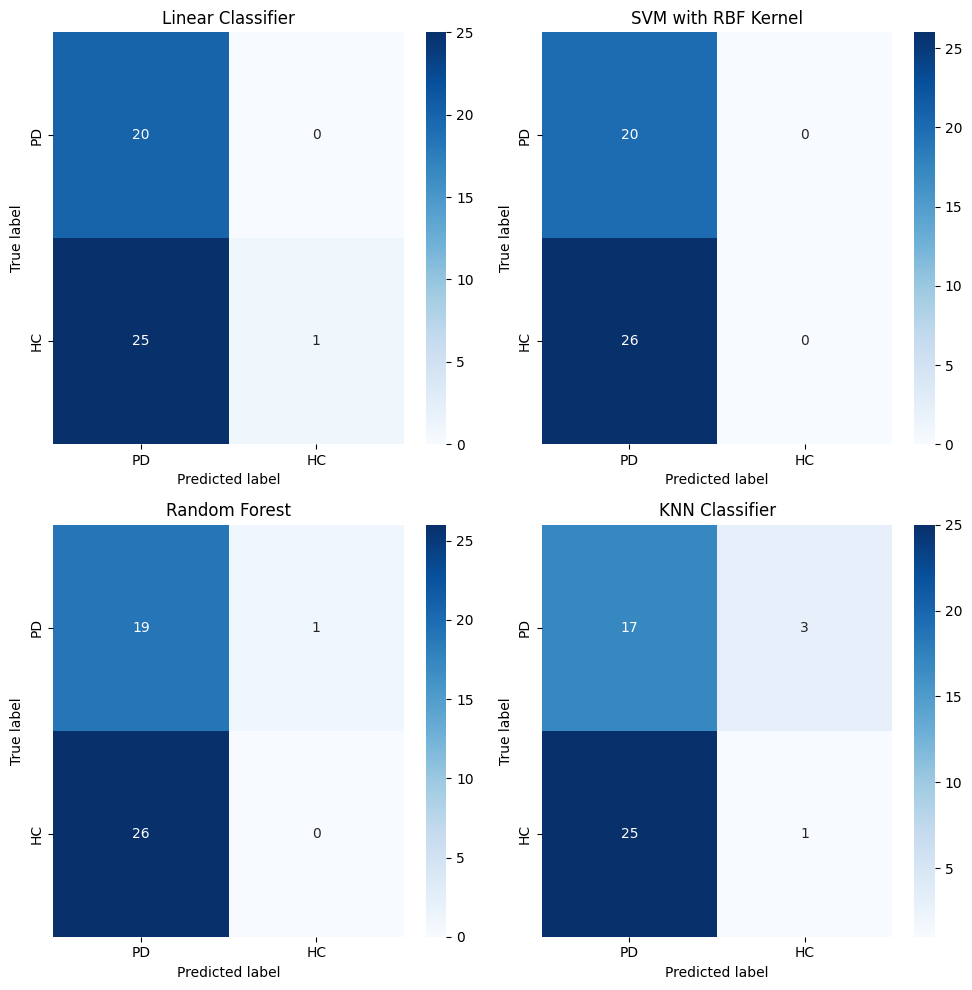

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


#**ViT Model-2: Base, patch size =32**

In [ ]:
model_name = 'vit_base_patch32_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [07:37<00:00,  4.26it/s]


In [ ]:
print("Number of features obtained:", len(train_features))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)



Number of features obtained: 1952
Shape of train data: (1952, 768)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_base_patch32_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


100%|██████████| 46/46 [00:10<00:00,  4.22it/s]

Number of features obtained: 46
Shape of test data: (46, 768)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
# Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50,100], 'gamma': [0.01, 0.1, 1,10]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500], 'max_depth': [1,5, 10, 20]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------
from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(labels_test,prediction_knn))

# Print results
print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy=  0.782608695652174
Logistic regression:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.88      0.85      0.86        26

    accuracy                           0.85        46
   macro avg       0.84      0.85      0.85        46
weighted avg       0.85      0.85      0.85        46

[[17  3]
 [ 4 22]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 1, 'gamma': 0.01}
Best score  for SVM with Kernel RBF Classification:  0.5856121712899206
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.84      0.81      0.82        26

    accuracy                           0.80        46
   macro avg       0.80      0.80      0.80        46
weighted avg       0.81      0.80      0.80        46

[[16  4]
 [ 5 21]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 10, 'n_e

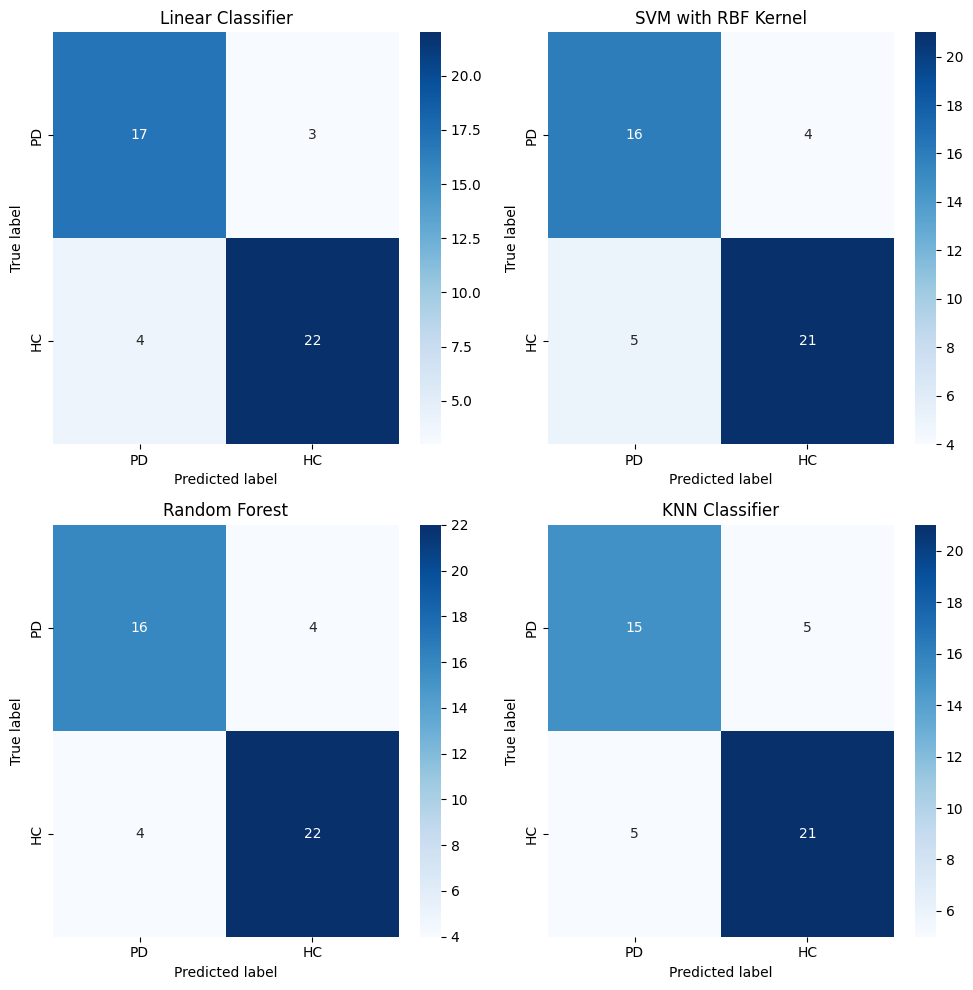

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


#**ViT Model 3: large, patch size=16**

In [ ]:
model_name = 'vit_large_patch16_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [1:38:50<00:00,  3.04s/it]


In [ ]:
print("Number of features obtained:", len(train_features))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)



Number of features obtained: 1952
Shape of train data: (1952, 1024)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_large_patch16_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]

Number of features obtained: 46
Shape of test data: (46, 1024)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
# Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50,100], 'gamma': [0.01, 0.1, 1,10]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500,1000], 'max_depth': [1,2,5, 10, 20]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------
from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(labels_test,prediction_knn))

# Print results
print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy=  0.782608695652174
Logistic regression:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.88      0.81      0.84        26

    accuracy                           0.83        46
   macro avg       0.82      0.83      0.82        46
weighted avg       0.83      0.83      0.83        46

[[17  3]
 [ 5 21]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 0.1, 'gamma': 0.01}
Best score  for SVM with Kernel RBF Classification:  0.5737713948455635
              precision    recall  f1-score   support

           0       0.43      1.00      0.61        20
           1       0.00      0.00      0.00        26

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46

[[20  0]
 [26  0]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 10, 'n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


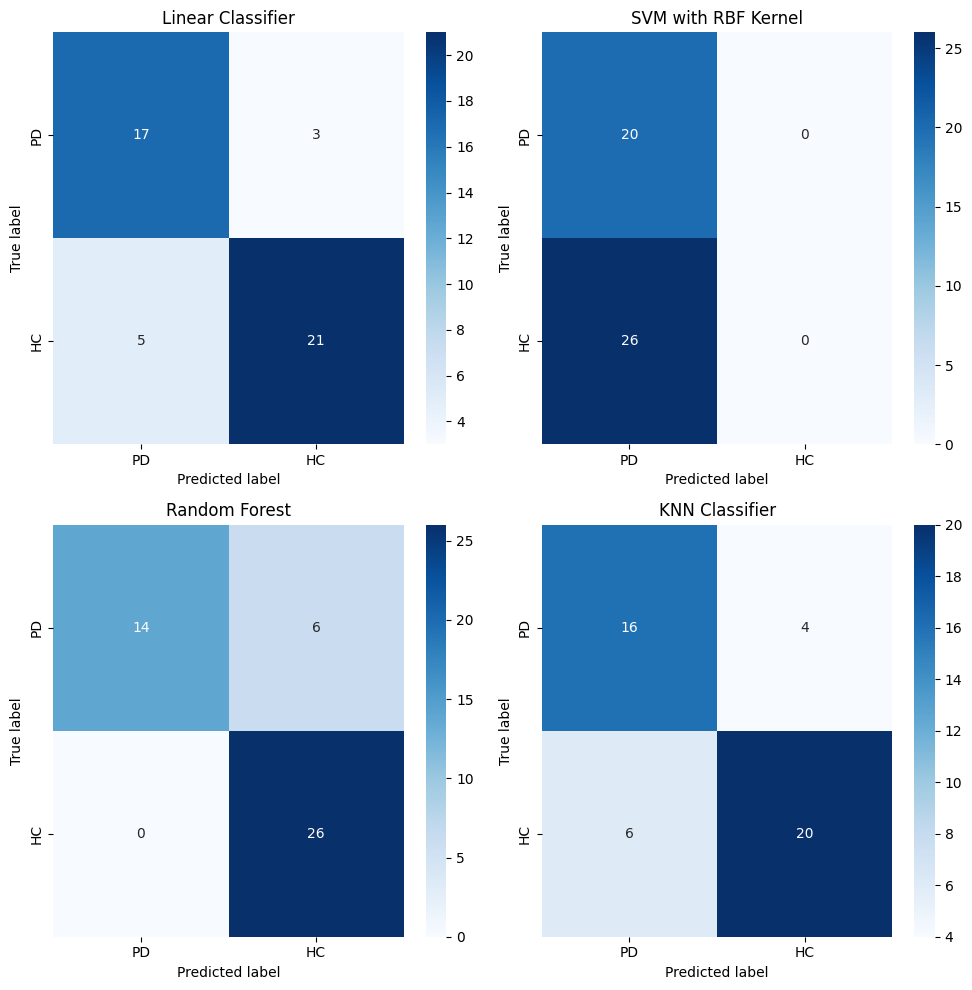

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


#**ViT Model-4: large, patch size=32**

In [ ]:
model_name = 'vit_large_patch32_224'
train_features,labels= extract_vit_features(train_path,model_name)

100%|██████████| 1952/1952 [29:21<00:00,  1.11it/s]


In [ ]:
print("Number of features obtained:", len(train_features))
train_array = np.array(train_features)
print("Shape of train data:", train_array.shape)



Number of features obtained: 1952
Shape of train data: (1952, 1024)


Similarly, we can obtain the features for test data.

In [ ]:
model_name = 'vit_large_patch32_224'
test_features,labels_test= extract_vit_features(test_path,model_name)

train_array = np.array(train_features)


print("Number of features obtained:", len(test_features))
test_array = np.array(test_features)
print("Shape of test data:", test_array.shape)


100%|██████████| 46/46 [00:41<00:00,  1.12it/s]

Number of features obtained: 46
Shape of test data: (46, 1024)


**We will use L2 Logistic Regression, RBF Kernel SVM, Random Forest, and KNN for the classification task**

In [ ]:
# Load the data
X_train = train_array
y_train = labels
X_test = test_array
y_test = labels_test

#------------------MODEL 1-----------------------------------------
# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=2000, random_state=42)
lr.fit(X_train, y_train)

#-----------------MODEL 2-------------------------------------------
# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [ 1, 10,50,100], 'gamma': [0.001,0.01, 0.1, 1]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)

#-----------------MODEL 3-------------------------------------------
# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [50,100, 200], 'max_depth': [1,5, 10, 20]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)

#-----------------MODEL 4-------------------------------------------
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
knn.fit(X_train,y_train)
prediction_knn=knn.predict(X_test)
#prediction_knn1=le.inverse_transform(VGG19_prediction_knn)

#-----------------RESULTS-----------------------------------------------
from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(labels_test,prediction_knn))

# Print results
print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))
print('KNN:' )
print(classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,knn.predict(X_test)))


Accuracy=  0.43478260869565216
Logistic regression:
              precision    recall  f1-score   support

           0       0.43      1.00      0.61        20
           1       0.00      0.00      0.00        26

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46

[[20  0]
 [26  0]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 10, 'gamma': 0.01}
Best score  for SVM with Kernel RBF Classification:  0.5742868384812118
              precision    recall  f1-score   support

           0       0.43      1.00      0.61        20
           1       0.00      0.00      0.00        26

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

[[20  0]
 [26  0]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 1, 'n_estimators': 50}
Best score  for Random Forest Classification:  0.5737713948455635
              precision    recall  f1-score   support

           0       0.43      1.00      0.61        20
           1       0.00      0.00      0.00        26

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46

[[20  0]
 [26  0]]
KNN:
              precision    recall  f1-score   support

           0       0.43      1.00      0.61        20
           1       0.00      0.00      0.00        26

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46

[[20  0]
 [26  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

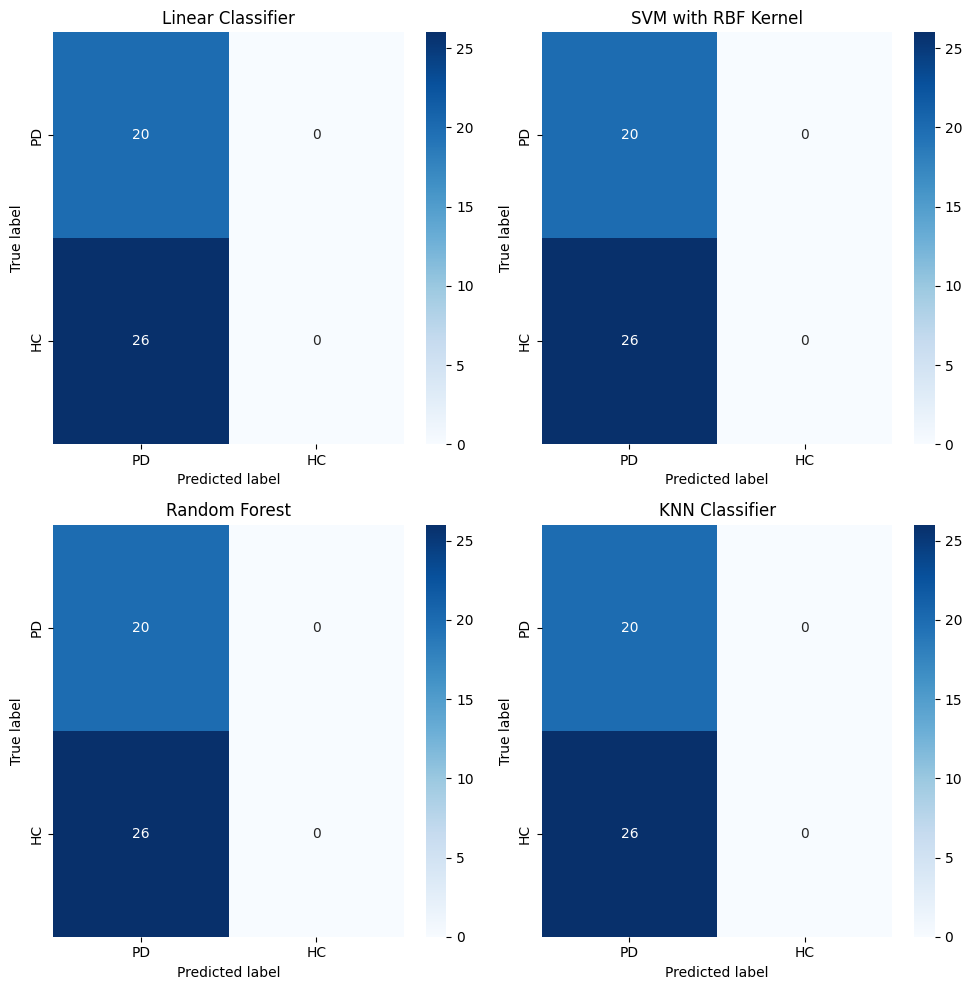

In [ ]:
#------------------------------------PLOT CONFUSION MATRICES FOR THE FOUR CLASSIFIERS---------------------------------------------------
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names and true labels
class_names = ['PD', 'HC']
y_true = np.random.randint(0, 2, size=100)  # generate random true labels for 100 samples

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)  # plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# Generate some random predicted labels for the 4 classifiers
y_pred1 = lr.predict(X_test)
y_pred2 = svm_gs.predict(X_test)
y_pred3 = rf_gs.predict(X_test)
y_pred4 = prediction_knn

# Create 2x2 subplot grid to plot the confusion matrices for the 4 classifiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot the confusion matrix for each classifier
plot_confusion_matrix(y_test, y_pred1, class_names, axes[0, 0])
axes[0, 0].set_title('Linear Classifier')

plot_confusion_matrix(y_test, y_pred2, class_names, axes[0, 1])
axes[0, 1].set_title('SVM with RBF Kernel')

plot_confusion_matrix(y_test, y_pred3, class_names, axes[1, 0])
axes[1, 0].set_title('Random Forest')

plot_confusion_matrix(y_test, y_pred4, class_names, axes[1, 1])
axes[1, 1].set_title('KNN Classifier')

plt.tight_layout()
plt.show()


**Feature Extraction by Building ViT Model from Scratch**

We can edit different parameters like patch size and Number of epochs by using the below code.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Reference : https://keras.io/examples/vision/image_classification_with_vision_transformer/